In [1]:
# Imports and notebook statements
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%load_ext line_profiler

import torch
from torch.nn.functional import conv2d, relu_
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from sklearn.linear_model import LinearRegression

from utils import *

import warnings
warnings.filterwarnings('ignore')

In [26]:
# STDP kernel time constant in seconds.  Used for the default kernel.
STDP_TIME_CONSTANT = 0.012

def w_0(x):
    """
    @param x (numpy array)
    A distance
    """
    a = 1.00
    lambda_net = 13.0
    beta = 3.0 / lambda_net ** 2
    gamma = 1.05 * beta

    return a * np.exp(-gamma * x) - np.exp(-beta * x)

def w_1(x):
    """
    @param x (numpy array)
    A distance
    """
    lambda_net = 13.0
    beta = 3.15 / lambda_net ** 2

    return - np.exp(-beta * x)   

# Random walk builder
def buildTrajectory(length, stepSize, width=1., directionStability=0.95, wrap=False):
    trajectory = np.zeros((int(length), 2))
    x = np.random.rand()
    y = np.random.rand()
    direction = np.random.rand() * 2 * np.pi
    twopi = 2*np.pi
    for i in range(int(length)):
        while True:
            # This is a random value between (-180, +180) scaled by directionStability
            dirChange = (((np.random.rand() * twopi) - np.pi) *
                       (1.0 - directionStability))
            direction = (direction + dirChange) % twopi
            rotation = np.asarray([np.cos(direction), np.sin(direction)])
            movement = stepSize*rotation
            if 0 < (movement[0] + x) < 1 and 0 < (movement[1] + y) < 1 or wrap:
                x += movement[0]
                y += movement[1]
                trajectory[i] = (x, y)
                break

    return(trajectory)

In [212]:
class GCN2D(object):
    
    def __init__(self,
                 numX,
                 numY,
                 inhibitionWindow,
                 inhibitionRadius,                 
                 inhibitionStrength,
                 boostEffect=10,
                 boostDecay=3.,
                 dt=0.001,
                 numPlaces=200,
                 globalTonic=20,
                 decayConstant=0.03,
                 envelopeWidth=0.25,
                 envelopeFactor=10,
                 stdpWindow=10,
                 sigmaLoc=0.05,
                 learningRate=0.015,
                 negativeLearnFactor=.9,
                 initialWeightFactor=.2,
                 weightDecay=60,
                 boostGradientX=1,
                 wideningFactor=0,
                ):
        self.activity = torch.zeros([1., 1., numX, numY], device=device, dtype=torch.float)
        self.filter = torch.zeros([1, 1, 1+2*inhibitionWindow, 1+2*inhibitionWindow], dtype=torch.float,
                                 device=device)
        self.numX = numX
        self.numY = numY
        self.numPlaces=numPlaces
        
        for i in range(1+2*inhibitionWindow):
            for j in range(1+2*inhibitionWindow):
                xComp = np.abs(i - (inhibitionWindow))
                yComp = np.abs(j - (inhibitionWindow))
                dist = np.asarray((xComp, yComp))
                dist = dist[0] ** 2 + dist[1] ** 2
                
                dist = max(dist - wideningFactor, 0)
                if dist <= 0:
                    weight = 0.
                else:
                    weight = w_1(dist/inhibitionRadius)*inhibitionStrength
                
                self.filter[0, 0, i, j] = weight
                
        self.activationHistory = torch.zeros([1, 1, numX, numY], device=device, dtype=torch.float)
        self.instantaneous = torch.zeros([1, 1, numX, numY], device=device, dtype=torch.float)
        self.boostEffect = torch.tensor(np.repeat(
            np.linspace(1, boostGradientX, self.numX)[:, np.newaxis], self.numY, axis=-1)*boostEffect,
                                       device=device, dtype=torch.float)
        self.boostDecay = boostDecay
        self.dt = dt
        self.globalTonic = torch.tensor([globalTonic], device=device, dtype=torch.float)
        self.decay = decayConstant
        self.inhibitionWindow = inhibitionWindow
        self.envelopeWidth = envelopeWidth
        self.envelopeFactor = envelopeFactor
        self.sigmaLoc = 0.01
        self.learningRate = learningRate
        self.negativeLearnFactor = negativeLearnFactor
        self.weightDecay = weightDecay
        
        self.zero = torch.zeros([1], device=device, dtype=torch.float)
        
        self.places = torch.tensor(np.random.rand(numPlaces, 2), device=device, dtype=torch.float)
        
        self.placeWeights = torch.tensor(np.random.rand(numX, numY, numPlaces)*initialWeightFactor,
                                         device=device, dtype=torch.float)
        
        self.placeActivity = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        
        self.envelope = torch.tensor(self.computeEnvelope(), device=device, dtype=torch.float)
        
        self.stdpWindow = stdpWindow

    
    def computeEnvelope(self):
        """
        Compute an envelope for use in suppressing border cells.
        :return: A numpy array that can be elementwise-multiplied with activations
                 for the given cell population to apply the envelope.
        """
#       envelope = np.zeros((self.numX, self.numY))
#         for i, ip in enumerate(np.linspace(-1, 1, self.numX)):
#             for j, jp in enumerate( np.linspace(-1, 1, self.numY)):
#                 dist = np.sqrt(ip**2 + jp**2)
#                 if dist < 1 - self.envelopeWidth:
#                     envelope[i, j] = 1.
#                 else:
#                     envelope[i, j] = np.exp(-1.*self.envelopeFactor *
#                           ((dist - 1 + self.envelopeWidth)/self.envelopeWidth)**2)
                
        envelopeX = [1 if self.numX/2. - np.abs(p) > self.envelopeWidth else
                          np.exp(-1.*self.envelopeFactor *
                          ((-self.numX/2. + np.abs(p) + self.envelopeWidth)/self.envelopeWidth)**2)
                          for p in np.arange(self.numX) - self.numX/2.]

        envelopeY = [1 if self.numY/2. - np.abs(p) > self.envelopeWidth else
                          np.exp(-1.*self.envelopeFactor *
                          ((-self.numY/2. + np.abs(p) + self.envelopeWidth)/self.envelopeWidth)**2)
                          for p in np.arange(self.numY) - self.numY/2.]

        return np.outer(envelopeX, envelopeY)
    
    def randomLesions(self, numLesions, lesionRadius, lesionInnerCutoff):
        lesions = []
        for i in range(numLesions):
            x = int(np.random.rand()*self.numX)
            y = int(np.random.rand()*self.numY)
            lesions.append((x, y))
            
        radii = [lesionRadius] * numLesions
        cutoffs = [lesionInnerCutoff] * numLesions
        
        self.addLesions(lesions, radii, cutoffs)
    
    def addLesions(self, lesionCenters, lesionRadii, lesionInnerCutoffs):
        for center, radius, cutoff in zip(lesionCenters, lesionRadii, lesionInnerCutoffs):
            for x in range(self.numX):
                for y in range(self.numY):
                    distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)
                    if distance < cutoff:
                        self.envelope[x, y] = 0.
                    elif distance < radius:
                        value = (distance - cutoff)/(radius - cutoff)
                        self.envelope[x, y] = min(value, self.envelope[x, y])


        
    def step(self, speed=1, place=True): 
        if place:
            self.instantaneous = torch.matmul(self.placeWeights, self.placeActivity).view(1, 1, self.numX, self.numY)
        else:
            self.instantaneous.fill_(0.)
        self.instantaneous += conv2d(self.activity, self.filter, padding=self.inhibitionWindow)
        self.instantaneous *= self.envelope
        self.instantaneous += self.activationHistory * self.boostEffect
        self.instantaneous *= min(speed, 1)
        relu_(self.instantaneous)
        self.activity += (self.instantaneous - self.activity/self.decay)*self.dt
        #torch.min(self.activity, self.zero + 1., out=self.activity)
        self.activationHistory += (self.globalTonic - self.activity)*self.dt*self.envelope #torch.sum(self.activity)/torch.sum(self.envelope) - 
        self.activationHistory -= self.dt*self.activationHistory/self.boostDecay
        
        
    def simulate(self, time, logFreq = 10, startFrom = 0):
        self.activity = torch.tensor(np.random.rand(1, 1, self.numX, self.numY)*0.1, device=device,
                                                 dtype=torch.float)
        
        self.activationHistory.fill_(self.globalTonic[0])
        
        numSteps = int(time/self.dt)
        numLogs = int(((time - startFrom)/self.dt)/logFreq)
        output = torch.zeros([numLogs, self.numX, self.numY], device=device, dtype=torch.float)
        
        s = 0
        for t in range(numSteps):
            self.step(place=False)
            if t % logFreq == 0 and t*self.dt >= startFrom:
                print("At {}".format(t*self.dt))
                output[s].copy_(self.activity.view(self.numX, self.numY))
                s += 1
                
        return output.cpu().numpy()
    
    def decayWeights(self):
        """
        Only decay place weights
        """
        self.placeWeights -= self.dt*self.placeWeights/self.weightDecay
    
    def learn(self, time, plotting=True, plotInterval=100, runLength=10, oneD=False):
        if plotting:
                fig, (ax1, ax2, ax3) = plt.subplots(3,1)
                ax1.scatter(self.places[:, 0].cpu().numpy(),
                    self.places[:, 1].cpu().numpy(),
                    c = self.placeActivity.cpu().numpy(),
                    cmap = plt.get_cmap("coolwarm"))
                ax2.matshow(self.activity.view((self.numX, self.numY)).cpu().numpy())
                im = ax3.scatter(self.places[:, 0].cpu().numpy(),
                            self.places[:, 1].cpu().numpy(),
                            c = self.placeWeights[self.numX//2, self.numY//2, :].cpu().numpy(),
                            cmap = plt.get_cmap("coolwarm"))
                fig.colorbar(im, ax=ax3)
                plt.show()
                
        self.activityBuffer = torch.zeros([self.stdpWindow, self.numX*self.numY],
                                          device=device, dtype=torch.float)
        self.placeBuffer = torch.zeros([self.stdpWindow, self.numPlaces],
                                       device=device, dtype=torch.float)
        
        self.stdpValues = torch.tensor(np.exp(-self.dt*np.arange(0, self.stdpWindow)/STDP_TIME_CONSTANT),
                                       device=device, dtype=torch.float)*self.learningRate*self.dt
        self.bufferIndex = 0
        
        times = np.arange(0, time, self.dt)
        
        self.activity = torch.tensor(np.random.rand(1, 1, self.numX, self.numY)*0.1, device=device,
                                                 dtype=torch.float)
        self.activationHistory.fill_(self.globalTonic[0])
        self.activationHistory *= self.envelope
        #trajectory = np.zeros((len(times), 2))
        
#         trajectories = []
#         times = []
#         oldPosition=np.asarray([0.5, 0.5])
#         for t in np.arange(0, time, runLength):
#             currentTimes = np.arange(0, runLength, self.dt)
#             newDest = np.random.sample((2,))
#             movement = np.sin(currentTimes*np.pi/(runLength*2))
#             trajectory = np.outer(movement, newDest) + np.outer(1 - movement, oldPosition)
            
#             trajectories.append(trajectory)
#             times.append(currentTimes + t)
#             oldPosition = newDest
            
#         trajectory = np.concatenate(trajectories, axis=0)
#         times = np.concatenate(times)
            
        #trajectory[:, 0] = (np.sin((times * np.pi / (10*1.34754)) + offsets[0]) + 1)/2
        #trajectory[:, 1] = (np.sin((times * np.pi / (10*1.6383478)) + offsets[1]) + 1)/2
        
        trajectory = buildTrajectory(len(times), 1*self.dt, wrap=True, directionStability=0.95)
        
        if oneD:
              trajectory[:, 1] = 0.
        velocity = np.diff(trajectory, axis=0)/self.dt
        
        trajectory = np.mod(trajectory, 1)
        trajectory = torch.tensor(trajectory, device=device, dtype=torch.float)
        velocity = torch.tensor(velocity, device=device, dtype=torch.float)
        speed = torch.norm(velocity, 2, dim=-1)
        distances = torch.zeros((self.numPlaces, 2), device=device, dtype=torch.float)
        
        for i, t in enumerate(times[:-1]):
            pos = trajectory[i, :]
            s = min(speed[i]/torch.mean(speed), 1.)
            distances[:,0] = torch.min(torch.abs(self.places[:,0] - pos[0]), 1 - torch.abs(self.places[:,0] - pos[0]))
            if not oneD:
                distances[:,1] = torch.min(torch.abs(self.places[:,1] - pos[1]), 1 - torch.abs(self.places[:,1] - pos[1]))
            else:
                distances[:,1] = 0.
            torch.exp(-1.*torch.norm(distances, 2, dim=-1)/(2*(self.sigmaLoc)), out=self.placeActivity)
            self.placeActivity *= s
            self.step(speed=s)
            self.stdpUpdate(i)
            torch.max(self.placeWeights, self.zero, out=self.placeWeights)
            torch.min(self.placeWeights, self.zero + 2., out=self.placeWeights)
           #self.placeWeights *= .6667/torch.mean(self.placeWeights, -1, keepdim=True)
            #self.decayWeights()
            if i % plotInterval == 0:
                if plotting:
                    ax1.scatter(self.places[:, 0].cpu().numpy(),
                        self.places[:, 1].cpu().numpy(),
                        c = self.placeActivity.cpu().numpy(),
                        cmap = plt.get_cmap("coolwarm"))
                    ax2.matshow(self.activity.view((self.numX, self.numY)).cpu().numpy())
                    im = ax3.scatter(self.places[:, 0].cpu().numpy(),
                                self.places[:, 1].cpu().numpy(),
                                c = self.placeWeights[self.numX//2, self.numY//2, :].cpu().numpy(),
                                cmap = plt.get_cmap("coolwarm"))
                    ax1.set_title(str(t))
                    fig.canvas.draw()
                    
                
    def stdpUpdate(self, time, clearBuffer=False):
        if time < self.activityBuffer.shape[0]:
            self.activityBuffer[self.bufferIndex].copy_(self.activity.view(self.numX*self.numY,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            self.bufferIndex += 1
            
        else:
            for t in range(self.stdpWindow):
                i = (self.bufferIndex - t) % self.stdpWindow
                self.placeWeights += torch.ger(self.activity.view(self.numX*self.numY), self.placeBuffer[i]* \
                                        self.stdpValues[t]).view(self.numX, self.numY, self.numPlaces)
                self.placeWeights -= (torch.ger(self.activityBuffer[i], self.placeActivity) *\
                                        self.stdpValues[t]).view(self.numX, self.numY, self.numPlaces) *\
                                      self.negativeLearnFactor
                
            self.bufferIndex = (self.bufferIndex + 1) % self.stdpWindow
            self.activityBuffer[self.bufferIndex].copy_(self.activity.view(self.numX*self.numY,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            
            
        if clearBuffer:
            pass

<IPython.core.display.Javascript object>


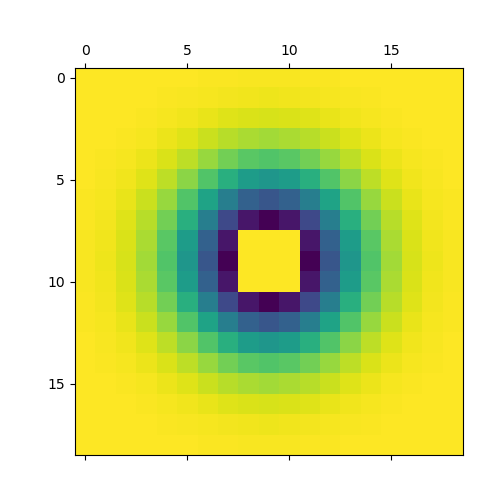

<IPython.core.display.Javascript object>


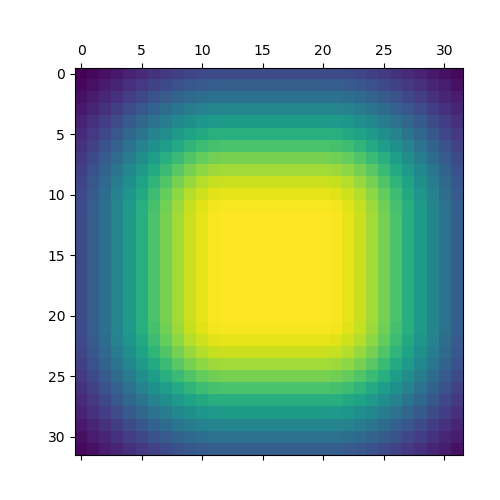

In [218]:
plt.rcParams['figure.figsize'] = [5, 5]

GCN = GCN2D(32,
            32,
            9,
            .3,
            25.,
            globalTonic=.25,
            stdpWindow=1,
            dt=0.01,
            boostEffect=50,
            boostDecay=100.,
            numPlaces=1000,
            learningRate=1.,
            initialWeightFactor=.1,
            boostGradientX=1,
            weightDecay=500,
            wideningFactor=2,
            negativeLearnFactor=1.,
            envelopeWidth=12,
            envelopeFactor=1.2,
            sigmaLoc=.0005)

#GCN.randomLesions(10, 10, 5)

plt.matshow(GCN.filter[0,0])
plt.show()

plt.matshow(GCN.envelope)
plt.show()


# plt.matshow(GCN.boostEffect)
# plt.show()

# plt.figure()
# plt.scatter(GCN.places[:, 0].cpu().numpy(),
#              GCN.places[:, 1].cpu().numpy())
# plt.show()

At 0.0
At 0.1
At 0.2
At 0.3
At 0.4
At 0.5
At 0.6
At 0.7000000000000001
At 0.8
At 0.9
At 1.0
At 1.1
At 1.2
At 1.3
At 1.4000000000000001
At 1.5
At 1.6
At 1.7
At 1.8
At 1.9000000000000001
At 2.0
At 2.1
At 2.2
At 2.3000000000000003
At 2.4
At 2.5
At 2.6
At 2.7
At 2.8000000000000003
At 2.9
At 3.0
At 3.1
At 3.2
At 3.3000000000000003
At 3.4
At 3.5
At 3.6
At 3.7
At 3.8000000000000003
At 3.9
At 4.0
At 4.1
At 4.2
At 4.3
At 4.4
At 4.5
At 4.6000000000000005
At 4.7
At 4.8
At 4.9
At 5.0
At 5.1000000000000005
At 5.2
At 5.3
At 5.4
At 5.5
At 5.6000000000000005
At 5.7
At 5.8
At 5.9
At 6.0
At 6.1000000000000005
At 6.2
At 6.3
At 6.4
At 6.5
At 6.6000000000000005
At 6.7
At 6.8
At 6.9
At 7.0
At 7.1000000000000005
At 7.2
At 7.3
At 7.4
At 7.5
At 7.6000000000000005
At 7.7
At 7.8
At 7.9
At 8.0
At 8.1
At 8.2
At 8.3
At 8.4
At 8.5
At 8.6
At 8.700000000000001
At 8.8
At 8.9
At 9.0
At 9.1
At 9.200000000000001
At 9.3
At 9.4
At 9.5
At 9.6
At 9.700000000000001
At 9.8
At 9.9
At 10.0
At 10.1
At 10.200000000000001
At 10.3
At

At 81.7
At 81.8
At 81.9
At 82.0
At 82.10000000000001
At 82.2
At 82.3
At 82.4
At 82.5
At 82.60000000000001
At 82.7
At 82.8
At 82.9
At 83.0
At 83.10000000000001
At 83.2
At 83.3
At 83.4
At 83.5
At 83.60000000000001
At 83.7
At 83.8
At 83.9
At 84.0
At 84.10000000000001
At 84.2
At 84.3
At 84.4
At 84.5
At 84.60000000000001
At 84.7
At 84.8
At 84.9
At 85.0
At 85.10000000000001
At 85.2
At 85.3
At 85.4
At 85.5
At 85.60000000000001
At 85.7
At 85.8
At 85.9
At 86.0
At 86.10000000000001
At 86.2
At 86.3
At 86.4
At 86.5
At 86.60000000000001
At 86.7
At 86.8
At 86.9
At 87.0
At 87.10000000000001
At 87.2
At 87.3
At 87.4
At 87.5
At 87.60000000000001
At 87.7
At 87.8
At 87.9
At 88.0
At 88.10000000000001
At 88.2
At 88.3
At 88.4
At 88.5
At 88.60000000000001
At 88.7
At 88.8
At 88.9
At 89.0
At 89.10000000000001
At 89.2
At 89.3
At 89.4
At 89.5
At 89.60000000000001
At 89.7
At 89.8
At 89.9
At 90.0
At 90.10000000000001
At 90.2
At 90.3
At 90.4
At 90.5
At 90.60000000000001
At 90.7
At 90.8
At 90.9
At 91.0
At 91.10000000

<IPython.core.display.Javascript object>


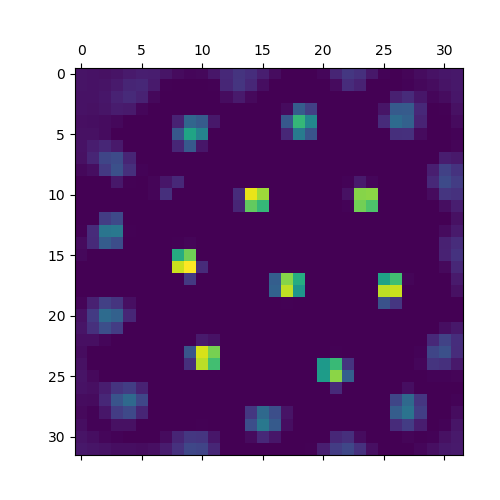

In [214]:
plt.rcParams['figure.figsize'] = [5, 5]
results = GCN.simulate(100, logFreq=10, startFrom = 0)
plt.matshow(results[-2])
plt.show()

In [219]:
plt.rcParams['figure.figsize'] = [5, 15]
for i in range(1000):
    print(i, GCN.learningRate)
    GCN.learningRate /= 1.01
    GCN.learn(25, plotting=False, plotInterval=1000, oneD=True)
    weights = GCN.placeWeights.cpu().numpy()
    if i % 50 == 0:
        with open("PlaceWeights{}.npz".format(i), "wb") as f:
            np.savez(f, weights)

0 1.0
1 0.9900990099009901
2 0.9802960494069208
3 0.9705901479276444
4 0.9609803444828162
5 0.9514656876067488
6 0.9420452352542067
7 0.9327180547071353
8 0.9234832224823122
9 0.914339824239913
10 0.9052869546929831
11 0.896323717517805
12 0.8874492252651535
13 0.8786625992724292
14 0.8699629695766625
15 0.8613494748283788
16 0.8528212622063156
17 0.8443774873329858
18 0.8360173141910751
19 0.8277399150406684
20 0.8195444703372954
21 0.8114301686507875
22 0.8033962065849382
23 0.7954417886979586
24 0.7875661274237213
25 0.7797684429937835
26 0.7720479633601817
27 0.7644039241189917
28 0.7568355684346453
29 0.7493421469649953
30 0.741922917787124
31 0.7345771463238852
32 0.7273041052711734
33 0.7201030745259143
34 0.7129733411147666
35 0.7059141991235313
36 0.6989249496272587
37 0.6920049006210482
38 0.685153366951533
39 0.6783696702490425
40 0.6716531388604381
41 0.665003107782612
42 0.6584189185966455
43 0.6518999194026193
44 0.6454454647550686
45 0.6390549155990778
46 0.6327276392070

353 0.029823255879923107
354 0.029527976118735748
355 0.029235619919540344
356 0.028946158336178557
357 0.02865956270908768
358 0.02837580466246305
359 0.028094856101448566
360 0.027816689209355015
361 0.027541276444905956
362 0.027268590539510848
363 0.026998604494565197
364 0.026731291578777423
365 0.0264666253255222
366 0.02620457953022
367 0.02594512824774257
368 0.02568824578984413
369 0.02543390672261795
370 0.02518208586397817
371 0.024932758281166506
372 0.02468589928828367
373 0.024441484443845217
374 0.0241994895483616
375 0.023959890641942178
376 0.02372266400192295
377 0.02348778614051777
378 0.023255233802492843
379 0.0230249839628642
380 0.02279701382461802
381 0.022571300816453487
382 0.022347822590548006
383 0.02212655702034456
384 0.02190748219836095
385 0.021690576434020743
386 0.021475818251505685
387 0.02126318638762939
388 0.02105265978973207
389 0.02084421761359611
390 0.020637839221382286
391 0.02043350417958642
392 0.020231192257016258
393 0.020030883422788373
3

680 0.0011520354090545377
681 0.0011406291178757799
682 0.0011293357602730494
683 0.001118154218092128
684 0.0011070833842496317
685 0.0010961221626233978
686 0.0010852694679439581
687 0.0010745242256870872
688 0.0010638853719674131
689 0.0010533518534330823
690 0.0010429226271614677
691 0.0010325966605559086
692 0.0010223729312434737
693 0.0010122504269737364
694 0.001002228145518551
695 0.0009923050945728226
696 0.0009824802916562601
697 0.0009727527640160991
698 0.0009631215485307912
699 0.0009535856916146447
700 0.0009441442491234107
701 0.0009347962862608026
702 0.0009255408774859432
703 0.0009163771064217259
704 0.0009073040657640851
705 0.0008983208571921635
706 0.0008894265912793698
707 0.0008806203874053166
708 0.0008719013736686303
709 0.0008632686868006241
710 0.0008547214720798259
711 0.0008462588832473523
712 0.0008378800824231211
713 0.0008295842400228922
714 0.0008213705346761308
715 0.000813238153144684
716 0.0008051862902422614
717 0.0007972141487547142
718 0.000789320

993 5.115355649980001e-05
994 5.0647085643366346e-05
995 5.0145629349867666e-05
996 4.9649137970166005e-05
997 4.9157562346699016e-05
998 4.867085380861289e-05
999 4.8188964166943455e-05


In [ ]:
print(torch.max(GCN.activity)[0])
print(torch.max(GCN.placeWeights, dim=-1)[0])
print(torch.min(GCN.placeWeights, dim=-1)[0])
print(torch.mean(GCN.placeWeights, dim=-1))

<IPython.core.display.Javascript object>


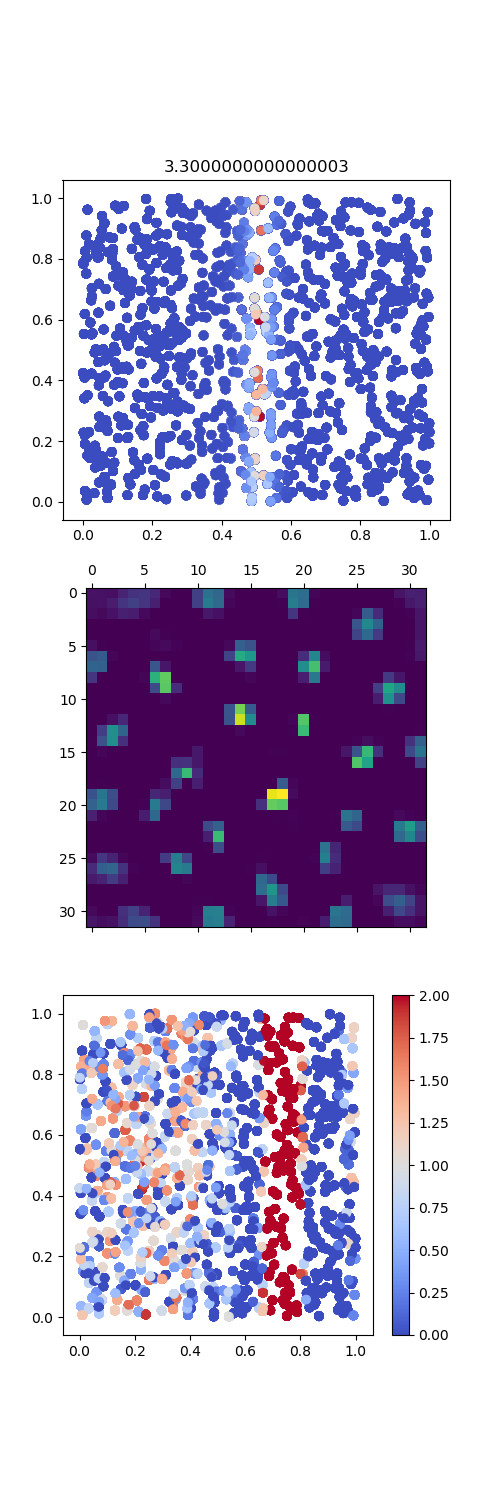

KeyboardInterrupt: 

In [222]:
plt.rcParams['figure.figsize'] = [5, 15]
GCN.learn(5000, plotting=True, plotInterval=10, oneD=True)

<IPython.core.display.Javascript object>


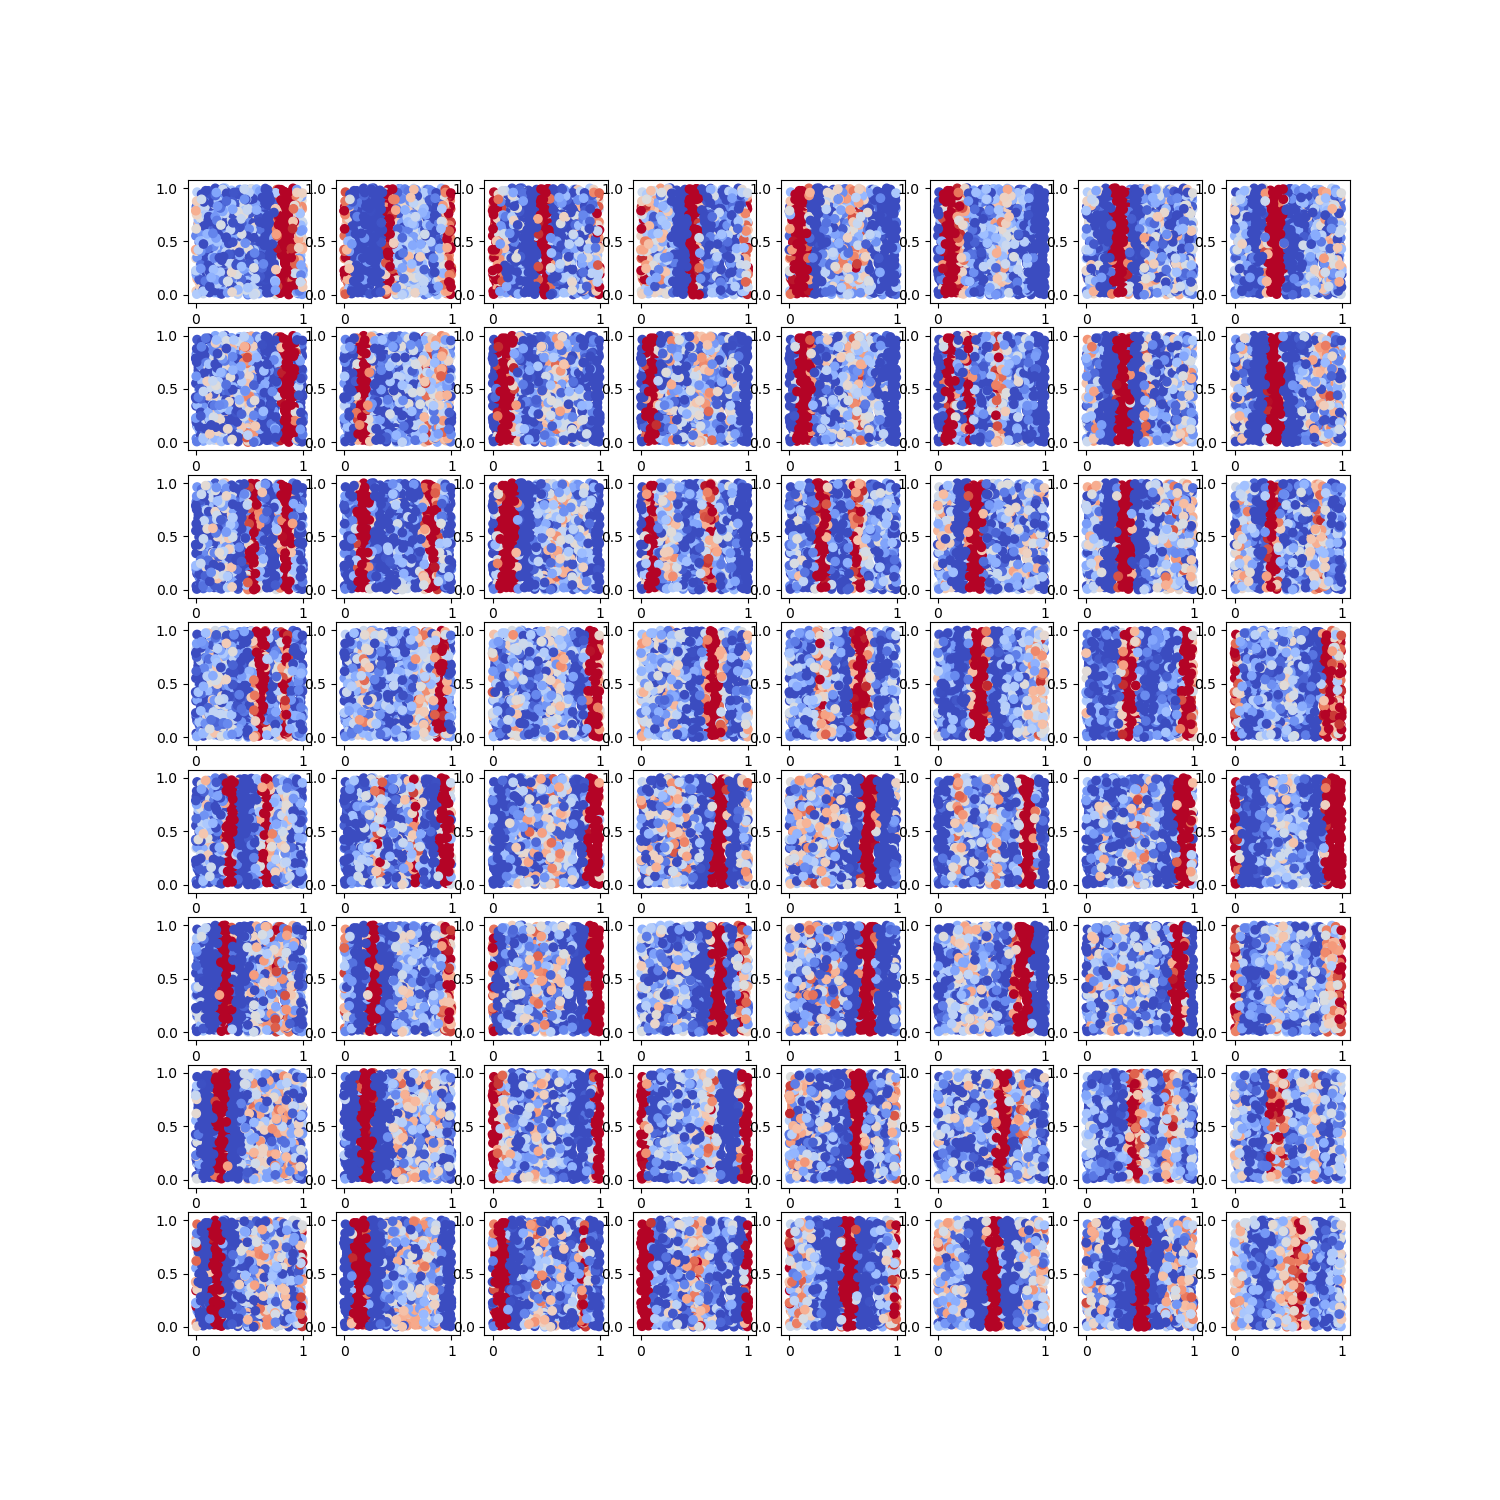

In [220]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
start = 12
end = 20
for i in range(start, end):
    for j in range(start, end):
        index = (i - start)*(end - start) + (j - start) + 1
        plt.subplot((end - start), (end - start), index)
        plt.scatter(GCN.places[:, 0].cpu().numpy(),
                    GCN.places[:, 1].cpu().numpy(),
                    c = GCN.placeWeights[i, j, :].cpu().numpy(),
                    cmap = plt.get_cmap("coolwarm"))
        plt.draw()


In [ ]:
mask = np.zeros((GCN.numX, GCN.numY))

for i in range(0, GCN.numX, 1):
    for j in range(0, GCN.numY, 1):
        mask[i, j] = 1.

processedResults, flowVelocities, flowColors = get_data_flow_and_color_maps(results[1100:1150], GCN.numX, GCN.numY, mask, 1)
processedResults = processedResults.reshape(-1, GCN.numX, GCN.numY)
flowColors = flowColors.reshape(-1, GCN.numX, GCN.numY, 3)

In [ ]:
def createMovieWithFlow(data, colors, name):
    def update(num, data, a):
        results, flowColors = data
        a[0].set_data(results[num])
        a[1].set_data(flowColors[num])
        return a,

    fig, ax   = plt.subplots(1,2)

    a0  = ax[0].imshow(data[0], animated=True)
    a1  = ax[1].imshow(colors[0], animated=True)

    ani = animation.FuncAnimation(fig, update, data.shape[0] - 1, fargs=((data, colors,), (a0,a1)),
                                   interval=10, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)


In [ ]:
createMovieWithFlow(processedResults, flowColors,
                      "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\flowtest.mp4")

In [135]:
def createMovie(data, name, interval=10):
    def update_line(num, data, line):
        line.set_data(data[num])
        return line,
    
    fig, ax   = plt.subplots(1,1)

    a0  = ax.matshow(data[0], animated=True)
    ani = animation.FuncAnimation(fig, update_line, data.shape[0] - 1,
                                  fargs=(data, a0),
                                  interval=interval, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)


<IPython.core.display.Javascript object>


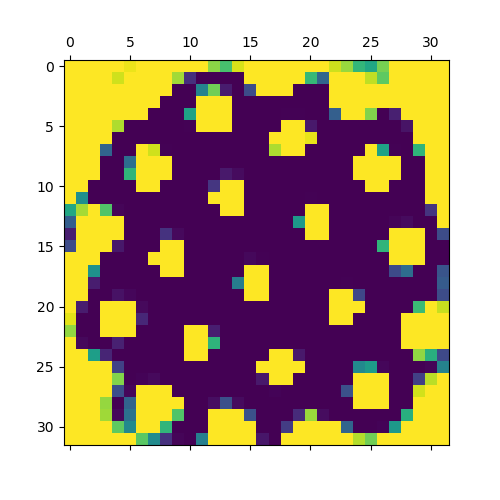

In [137]:
plt.rcParams['figure.figsize'] = [5, 5]
createMovie(results[-1000:], "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\test.mp4", .01)

<video controls src="./test.mp4" />